In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, Polygon
from sklearn.model_selection import KFold
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

In [2]:
# Load CONUS Boundary GeoJSON
state_path = "https://github.com/mapbox/mapboxgl-jupyter/raw/refs/heads/master/examples/data/us-states.geojson"
state_gdf = gpd.read_file(state_path)

# Keep CONUS states
state_gdf = state_gdf[~state_gdf['id'].isin(['02', '15', '72'])]

# Ensure it is in the correct projection (WGS84)
state_gdf = state_gdf.to_crs(epsg=4326)

# Get CONUS bounding box
minx, miny, maxx, maxy = state_gdf.total_bounds
print(f"Bounding Box: {minx, miny, maxx, maxy}")

Bounding Box: (-124.706553, 25.120779, -66.979601, 49.383625)


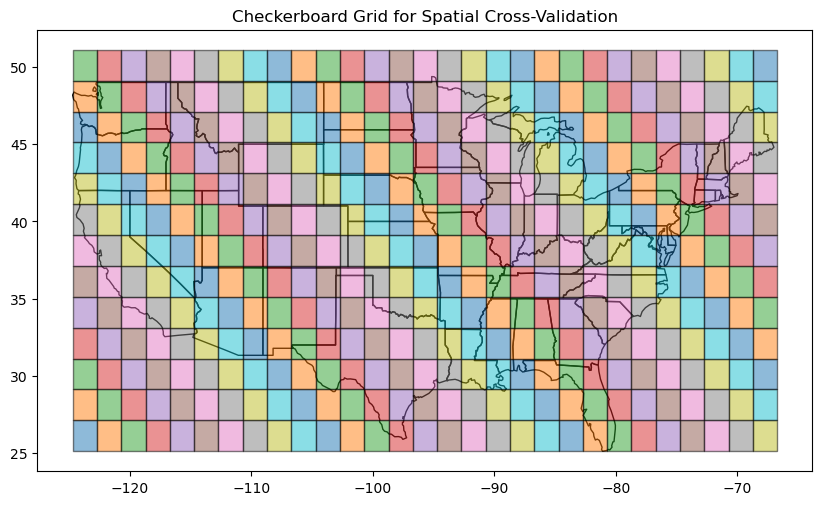

In [3]:
def create_checkerboard_grid(minx, miny, maxx, maxy, grid_size, n_folds=4):
    """
    Create a checkerboard spatial cross-validation grid.
    
    Parameters:
    - minx, miny, maxx, maxy: Bounding box coordinates
    - grid_size: Size of each grid cell in degrees
    - n_folds: Number of CV folds (e.g., 4 for a 4-color checkerboard pattern)
    
    Returns:
    - A GeoDataFrame containing the grid cells with fold assignments.
    """
    cols = int((maxx - minx) / grid_size) + 1
    rows = int((maxy - miny) / grid_size) + 1

    grid_cells = []
    fold_assignments = []

    for i in range(cols):
        for j in range(rows):
            x1 = minx + i * grid_size
            y1 = miny + j * grid_size
            x2 = x1 + grid_size
            y2 = y1 + grid_size
            
            grid_cell = box(x1, y1, x2, y2)

            # Assign fold systematically in a checkerboard pattern
            fold_id = (i + j) % n_folds + 1  # Cycle through folds (1,2,3,4,...)
            
            grid_cells.append(grid_cell)
            fold_assignments.append(fold_id)

    grid_df = gpd.GeoDataFrame({'geometry': grid_cells, 'fold': fold_assignments}, crs="EPSG:4326")
    
    return grid_df

# Define grid size (e.g., 2 degrees resolution)
grid_size = 2.0  # Adjust as needed
n_folds = 10  # Four systematic folds

# Create grid
grid = create_checkerboard_grid(minx, miny, maxx, maxy, grid_size, n_folds)

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 6))
state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
grid.plot(ax=ax, column='fold', cmap='tab10', alpha=0.5, edgecolor='black')
plt.title("Checkerboard Grid for Spatial Cross-Validation")
plt.show()

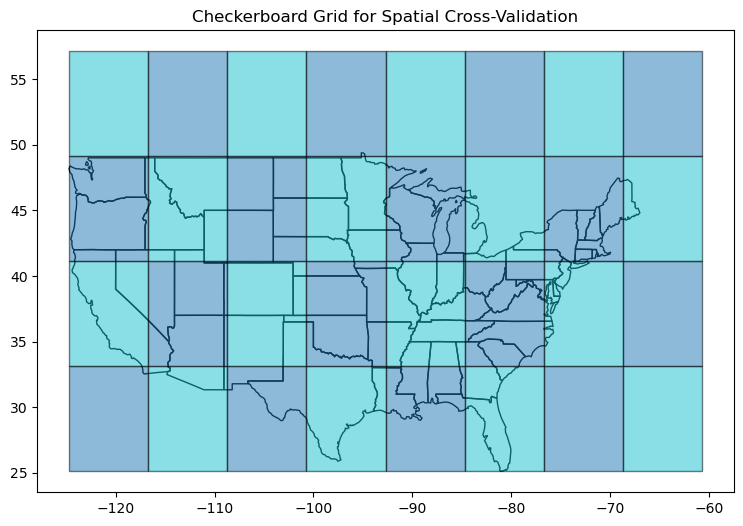

In [4]:
# Define grid size (e.g., 2 degrees resolution)
grid_size = 8.0  # Adjust as needed
n_folds = 2  # Four systematic folds

# Create grid
grid = create_checkerboard_grid(minx, miny, maxx, maxy, grid_size, n_folds)

# Plot the grid
fig, ax = plt.subplots(figsize=(10, 6))
state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
grid.plot(ax=ax, column='fold', cmap='tab10', alpha=0.5, edgecolor='black')
plt.title("Checkerboard Grid for Spatial Cross-Validation")
plt.show()

In [5]:
X = np.load("../data/X_2021.npy")
y = np.load("../data/y_2021.npy")

# Convert lat/lon points into GeoDataFrame
data_points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(X[:, -1, 5].ravel(), X[:, -1, 6].ravel())],
                               crs="EPSG:4326")

# Spatial join: Assign each data point to a grid cell (hence a fold)
data_with_folds = gpd.sjoin(data_points, grid, how="left", predicate="within")

# Extract fold assignments
folds = data_with_folds["fold"].values
print(f"Fold Distribution:\n{pd.Series(folds).value_counts(normalize=True)}")


Fold Distribution:
2    0.514272
1    0.485728
Name: proportion, dtype: float64


In [21]:
# Export folds index
# np.save("../data/X_2021_checkerboard_fold2_deg16_idx.npy", folds)

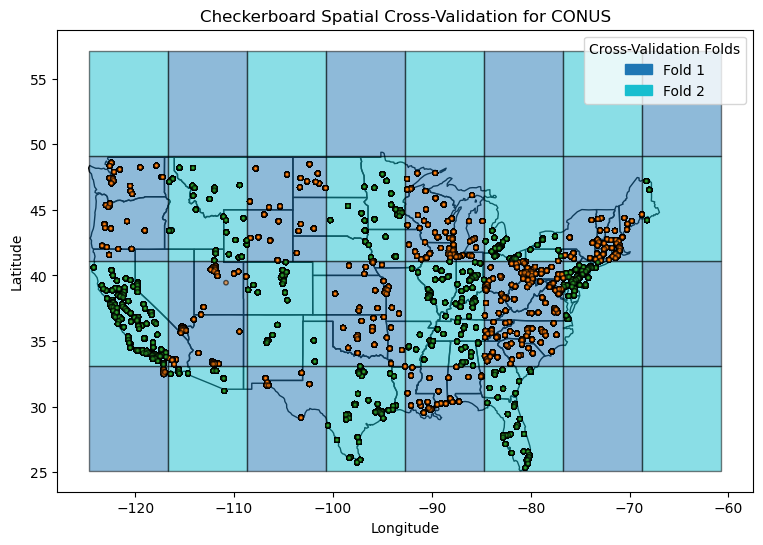

In [22]:
# Define a colormap for folds
cmap = plt.get_cmap("tab10")  # Or use "viridis" for more than 10 folds
unique_folds = sorted(grid["fold"].unique())

# Adjust norm based on the number of folds
norm = mcolors.BoundaryNorm(boundaries=np.arange(n_folds + 1) - 0.5, ncolors=n_folds)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot CONUS boundary
state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the checkerboard grid with fold colors
grid.plot(ax=ax, column='fold', cmap=cmap, alpha=0.5, edgecolor='black', legend=False)

# Plot data points colored by their assigned folds
scatter = ax.scatter(
    data_with_folds.geometry.x, data_with_folds.geometry.y,
    c=data_with_folds['fold'], cmap=cmap, norm=norm, edgecolors='k', s=10, alpha=0.6, label="Data Points"
)

# Create custom legend
legend_patches = [mpatches.Patch(color=cmap(i / max(n_folds - 1, 1)), label=f'Fold {i+1}') for i in range(n_folds)]
ax.legend(handles=legend_patches, title="Cross-Validation Folds", loc="upper right")

# Titles and labels
plt.title("Checkerboard Spatial Cross-Validation for CONUS")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show plot
plt.show()


Fold Distribution:
2    0.514272
1    0.485728
Name: proportion, dtype: float64


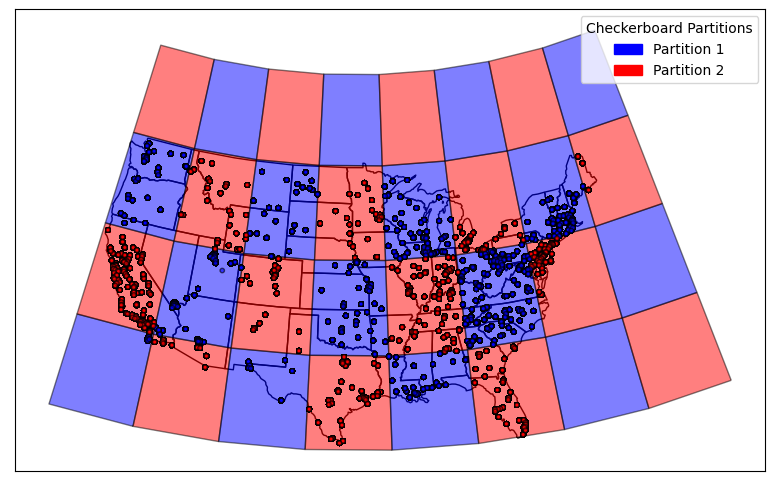

In [10]:
# Define grid size and number of partitions
grid_size = 8.0  # Adjust as needed (in degrees)
n_folds = 2       # Two partitions (e.g., one for train and one for test)

# Create grid in the native geographic coordinate system (EPSG:4326)
grid = create_checkerboard_grid(minx, miny, maxx, maxy, grid_size, n_folds)

# Load data points (EPSG:4326)
X = np.load("../data/X_2021.npy")
y = np.load("../data/y_2021.npy")
data_points = gpd.GeoDataFrame(
    geometry=[Point(lon, lat) for lat, lon in zip(X[:, -1, 5].ravel(), X[:, -1, 6].ravel())],
    crs="EPSG:4326"
)

# Perform spatial join in EPSG:4326 (degrees)
data_with_folds = gpd.sjoin(data_points, grid, how="left", predicate="within")
folds = data_with_folds["fold"].values
print(f"Fold Distribution:\n{pd.Series(folds).value_counts(normalize=True)}")

# Reproject state boundaries, grid, and joined data to NAD83 / Conus Albers (EPSG:5070)
state_gdf = state_gdf.to_crs("EPSG:5070")
grid = grid.to_crs("EPSG:5070")
data_with_folds = data_with_folds.to_crs("EPSG:5070")

# Adjust fold values if necessary (if folds are 1 and 2, shift them to 0 and 1)
data_with_folds['fold'] = data_with_folds['fold'].astype(int) - 1

# Create a custom colormap: blue for partition 0, red for partition 1
cmap = ListedColormap(["blue", "red"])
norm = BoundaryNorm(np.arange(n_folds + 1) - 0.5, ncolors=n_folds)

# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the CONUS boundary
state_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the checkerboard grid with the custom colormap
grid.plot(ax=ax, column='fold', cmap=cmap, alpha=0.5, edgecolor='black', legend=False)

# Plot data points colored by their partition using the same colormap
scatter = ax.scatter(
    data_with_folds.geometry.x,
    data_with_folds.geometry.y,
    c=data_with_folds['fold'],
    cmap=cmap,
    norm=norm,
    edgecolors='k',  # Black edge color for clarity
    s=10,
    alpha=0.6,
    zorder=5,
    label="Data Points"
)

# Create a custom legend for the partitions
legend_patches = [mpatches.Patch(color=cmap(i), label=f'Partition {i+1}') for i in range(n_folds)]
ax.legend(handles=legend_patches, title="Checkerboard Partitions", loc="upper right")

# Label axes
# plt.xlabel("Easting (meters)")
# plt.ylabel("Northing (meters)")
# Remove tick marks and tick labels but keep the bounding box (spines)
ax.set_xticks([])
ax.set_yticks([])

# Save the figure to a PNG file with dpi=300
plt.savefig(f"../fig/checkerboard_deg{grid_size}_partition.png", dpi=300, bbox_inches="tight")
plt.show()